In [ ]:
!pip install torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import time
import torch.utils.data as data_utils
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 31.7 MB/s 


Downloading cifar10 Dataset (32x32)

In [ ]:
(x_train32, y_train32), (x_test32, y_test32) = cifar10.load_data()

170498071/170498071 [==============================] - 17s 0us/step


In [ ]:
np.shape(x_train32)

(50000, 32, 32, 3)

16x16 resolution style

In [ ]:
x_train16=tf.image.resize(
  images=x_train32,
  size=[16,16],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
np.shape(x_train16)

x_test16=tf.image.resize(
  images=x_test32,
  size=[16,16],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
print(np.shape(x_test16))
################################
x_train16=tf.image.resize(
  images=x_train16,
  size=[32,32],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
np.shape(x_train16)

x_test16=tf.image.resize(
  images=x_test16,
  size=[32,32],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
# np.shape(x_test16)

(10000, 16, 16, 3)


8x8 resolution style

In [ ]:
x_train8=tf.image.resize(
  images=x_train32,
  size=[8,8],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
np.shape(x_train8)

x_test8=tf.image.resize(
  images=x_test32,
  size=[8,8],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
print(np.shape(x_test8))
####################
x_train8=tf.image.resize(
  images=x_train8,
  size=[32,32],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
np.shape(x_train8)

x_test8=tf.image.resize(
  images=x_test8,
  size=[32,32],
  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  preserve_aspect_ratio=False,
  antialias=False,
  name=None
  ).numpy()
# np.shape(x_test8)

(10000, 8, 8, 3)


A) Showing different resolution styles for 10 random images

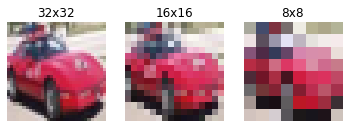

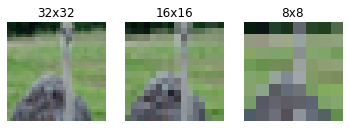

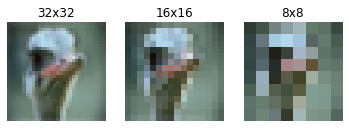

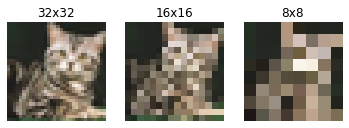

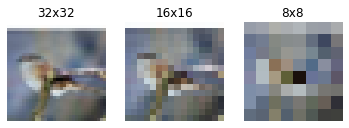

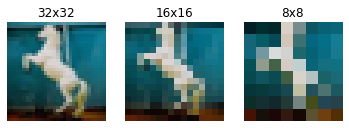

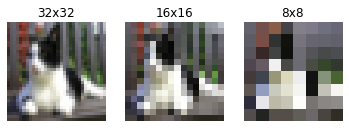

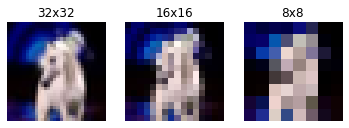

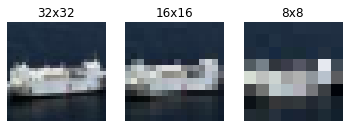

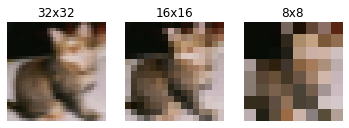

In [ ]:
samples=np.random.randint(len(x_train32),size=(10))
for i,index in zip(range(10),samples):
  ax1=plt.subplot(1,3,1)
  plt.imshow(x_train32[index])
  plt.title("32x32")
  plt.axis('off')
  ax2=plt.subplot(1,3,2)
  plt.imshow(x_train16[index])
  plt.title("16x16")
  plt.axis('off')
  ax3=plt.subplot(1,3,3)
  plt.imshow(x_train8[index])
  plt.title("8x8")
  plt.axis('off')
  plt.show()

changing datatypes from numpy to tensor

In [ ]:
#32x32
x_train32=torch.tensor(x_train32, dtype=torch.float32)
y_train32=torch.tensor(y_train32, dtype=torch.float32)

x_test32=torch.tensor(x_test32, dtype=torch.float32)
y_test32=torch.tensor(y_test32, dtype=torch.float32)

#16x16
x_train16=torch.tensor(x_train16, dtype=torch.float32)
y_train16=torch.tensor(y_train32, dtype=torch.float32)

x_test16=torch.tensor(x_test16, dtype=torch.float32)
y_test16=torch.tensor(y_test32, dtype=torch.float32)

#8x8
x_train8=torch.tensor(x_train8, dtype=torch.float32)
y_train8=torch.tensor(y_train32, dtype=torch.float32)

x_test8=torch.tensor(x_test8, dtype=torch.float32)
y_test8=torch.tensor(y_test32, dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Class Dataset

In [ ]:
class Dataset():
  def __init__(self, x, y, k):
    self.x = x
    self.yy = np.zeros((self.x.shape[0], k))
    for i in range(self.x.shape[0]):
      self.yy[i][int(y[i])] = 1 

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.yy[index]

Dataloder

In [ ]:
K=len(np.unique(y_train32))

#32x32
training_set32=Dataset(x_train32,y_train32,K)
training_generator32 = torch.utils.data.DataLoader(training_set32,batch_size=2000,shuffle=True)

validation_set32=Dataset(x_test32,y_test32,K)
validation_generator32 = torch.utils.data.DataLoader(validation_set32,batch_size=2000,shuffle=False)

# 16x16
training_set16=Dataset(x_train16,y_train16,K)
training_generator16 = torch.utils.data.DataLoader(training_set16,batch_size=2000,shuffle=True)

validation_set16=Dataset(x_test16,y_test16,K)
validation_generator16 = torch.utils.data.DataLoader(validation_set16,batch_size=2000,shuffle=False)

# 8x8
training_set8=Dataset(x_train8,y_train8,K)
training_generator8 = torch.utils.data.DataLoader(training_set8,batch_size=2000,shuffle=True)

validation_set8=Dataset(x_test8,y_test8,K)
validation_generator8 = torch.utils.data.DataLoader(validation_set8,batch_size=2000,shuffle=False)

In [ ]:
K=len(np.unique(y_train32))
print(K)

10


Defining CNN model

In [ ]:
class CNN(nn.Module):
  def __init__(self,K):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3)
    self.conv2 = nn.Conv2d(32,32,kernel_size=3)
    self.conv3 = nn.Conv2d(32,32,kernel_size=3)
    self.conv4 = nn.Conv2d(32,64,kernel_size=3)
    self.conv5 = nn.Conv2d(64,64,kernel_size=3)
    self.conv6 = nn.Conv2d(64,64,kernel_size=3)
    self.maxpool1=nn.MaxPool2d((2,2))
    self.maxpool2=nn.MaxPool2d((2,2))
    self.lin1 = nn.Linear(64 * 3 * 3, 512)
    self.lin2 = nn.Linear(512, K)
    self.drp1 = nn.Dropout(p=0.25)
    self.drp2 = nn.Dropout(p=0.5)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.maxpool1(x)
    x = self.drp1(x)#
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.maxpool2(x)
    x = self.drp1(x)
    x = x.contiguous().view(-1,64 * 3 * 3)
    x = F.relu(self.lin1(x))
    x = self.drp2(x)
    x = self.lin2(x)
    return x


Defining needed models for both TVTV and TOTV methods

In [ ]:
cifar10_model=CNN(K)
cifar10_model16=CNN(K)
cifar10_model8=CNN(K)
cifar10_model3216=CNN(K)
cifar10_model328=CNN(K)

Use gpu for Trainnig

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(device)
cifar10_model.to(device)
cifar10_model16.to(device)
cifar10_model8.to(device)
cifar10_model3216.to(device)
cifar10_model328.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=576, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=10, bias=True)
  (drp1): Dropout(p=0.25, inplace=False)
  (drp2): Dropout(p=0.5, inplace=False)
)

Optimization and criterion for both TVTV and TOTV methods

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar10_model.parameters(),lr=0.001)
optimizer16 = torch.optim.Adam(cifar10_model16.parameters(),lr=0.001)
optimizer8 = torch.optim.Adam(cifar10_model8.parameters(),lr=0.001)
optimizer3216 = torch.optim.Adam(cifar10_model3216.parameters(),lr=0.001)
optimizer328 = torch.optim.Adam(cifar10_model328.parameters(),lr=0.001)
metricF1=BinaryF1Score()
metricAcc=BinaryAccuracy()
metricPre=BinaryPrecision()
softmax = nn.Softmax(dim=1)

Trainig the model

In [ ]:
def train_loop(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses=np.zeros(epochs)
  valid_losses=np.zeros(epochs)
  Accuracy=np.zeros(epochs)

  for i in range(epochs):
    t0=datetime.now()
    train_loss=[]
    valid_loss=[]
    f1 = []
    accuracy = []
    precision=[]

    model.train()
    for datas, targets in train_loader:
      datas, targets= datas.to(device), targets.to(device)
      datas=torch.permute(datas,(0,3,1,2))
      optimizer.zero_grad()
      outputs=model(datas)
      loss=criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss=np.mean(train_loss)
    with torch.no_grad():
      model.eval()
      for datas, targets in valid_loader:
        datas, targets= datas.to(device), targets.to(device)
        datas=torch.permute(datas,(0,3,1,2))
        outputs=model(datas)
        outputs = softmax(outputs)
        loss=criterion(outputs, targets)
        valid_loss.append(loss.item())
        f1.append(metricF1(outputs.cpu(),targets.cpu()))
        accuracy.append(metricAcc(outputs.cpu(),targets.cpu()))
        precision.append(metricPre(outputs.cpu(),targets.cpu()))

    valid_loss=np.mean(valid_loss)
    f1=np.mean(f1)
    accuracy=np.mean(accuracy)
    precisionn=np.mean(precision)

    train_losses[i]=train_loss
    valid_losses[i]=valid_loss
    Accuracy[i]=accuracy

    delta_t=datetime.now()-t0

    # print(f'epoch {i+1}/{epochs}, train loss: {train_loss:.4f}, \
    #       validation loss: {valid_loss:.4f}, duration: {delta_t}')
    print(f'epoch {i+1}/{epochs}, f1: {f1:.4f}, \
          accuracy: {accuracy:.4f}, \
          precision: {precisionn:.4f}')
    
  return train_losses, valid_losses, Accuracy


TOTV and TVTV
32x32

In [ ]:
train_losses32, valid_losses32, accuracy32 = train_loop(cifar10_model, criterion, optimizer,
                                                        training_generator32,validation_generator32, epochs=75)

epoch 1/75, f1: 0.0135,           accuracy: 0.9003,           precision: 0.6509
epoch 2/75, f1: 0.0569,           accuracy: 0.9013,           precision: 0.6313
epoch 3/75, f1: 0.2101,           accuracy: 0.9050,           precision: 0.6222
epoch 4/75, f1: 0.2932,           accuracy: 0.9082,           precision: 0.6374
epoch 5/75, f1: 0.3671,           accuracy: 0.9132,           precision: 0.6775
epoch 6/75, f1: 0.3991,           accuracy: 0.9174,           precision: 0.7327
epoch 7/75, f1: 0.4501,           accuracy: 0.9216,           precision: 0.7541
epoch 8/75, f1: 0.4770,           accuracy: 0.9225,           precision: 0.7323
epoch 9/75, f1: 0.5135,           accuracy: 0.9247,           precision: 0.7258
epoch 10/75, f1: 0.5193,           accuracy: 0.9265,           precision: 0.7506
epoch 11/75, f1: 0.5518,           accuracy: 0.9299,           precision: 0.7649
epoch 12/75, f1: 0.5591,           accuracy: 0.9311,           precision: 0.7754
epoch 13/75, f1: 0.5803,           ac

TVTV
16x16

In [ ]:
train_losses16, valid_losses16, accuracy16 = train_loop(cifar10_model16, criterion, optimizer16,
                                    training_generator16,validation_generator16, epochs=100)

epoch 1/100, f1: 0.0018,           accuracy: 0.8999,           precision: 0.3690
epoch 2/100, f1: 0.1442,           accuracy: 0.9024,           precision: 0.5869
epoch 3/100, f1: 0.2510,           accuracy: 0.9078,           precision: 0.6703
epoch 4/100, f1: 0.3499,           accuracy: 0.9112,           precision: 0.6536
epoch 5/100, f1: 0.3801,           accuracy: 0.9157,           precision: 0.7167
epoch 6/100, f1: 0.4538,           accuracy: 0.9200,           precision: 0.7158
epoch 7/100, f1: 0.4574,           accuracy: 0.9211,           precision: 0.7330
epoch 8/100, f1: 0.4932,           accuracy: 0.9254,           precision: 0.7698
epoch 9/100, f1: 0.5183,           accuracy: 0.9263,           precision: 0.7484
epoch 10/100, f1: 0.5140,           accuracy: 0.9249,           precision: 0.7283
epoch 11/100, f1: 0.5490,           accuracy: 0.9305,           precision: 0.7817
epoch 12/100, f1: 0.5735,           accuracy: 0.9310,           precision: 0.7503
epoch 13/100, f1: 0.5649,

TVTV 8x8

In [ ]:
train_losses8, valid_losses8, accuracy8 = train_loop(cifar10_model8, criterion, optimizer8,
                                    training_generator8,validation_generator8, epochs=100)

epoch 1/100, f1: 0.0002,           accuracy: 0.9000,           precision: 0.2000
epoch 2/100, f1: 0.0279,           accuracy: 0.9005,           precision: 0.6119
epoch 3/100, f1: 0.1299,           accuracy: 0.9013,           precision: 0.5496
epoch 4/100, f1: 0.2380,           accuracy: 0.9062,           precision: 0.6351
epoch 5/100, f1: 0.2087,           accuracy: 0.9069,           precision: 0.6929
epoch 6/100, f1: 0.2544,           accuracy: 0.9085,           precision: 0.6868
epoch 7/100, f1: 0.2954,           accuracy: 0.9101,           precision: 0.6821
epoch 8/100, f1: 0.3306,           accuracy: 0.9121,           precision: 0.6940
epoch 9/100, f1: 0.3513,           accuracy: 0.9140,           precision: 0.7141
epoch 10/100, f1: 0.3599,           accuracy: 0.9144,           precision: 0.7129
epoch 11/100, f1: 0.3900,           accuracy: 0.9159,           precision: 0.7089
epoch 12/100, f1: 0.4180,           accuracy: 0.9157,           precision: 0.6755
epoch 13/100, f1: 0.4019,

TOTV 32x32->16x16

In [ ]:
train_losses_32, valid_losses_16, accuracy2 = train_loop(cifar10_model3216, criterion, optimizer3216,
                                    training_generator32,validation_generator16, epochs=100)

epoch 1/100, f1: 0.0002,           accuracy: 0.9000,           precision: 0.2000
epoch 2/100, f1: 0.1362,           accuracy: 0.9025,           precision: 0.5966
epoch 3/100, f1: 0.2283,           accuracy: 0.9061,           precision: 0.6413
epoch 4/100, f1: 0.2397,           accuracy: 0.9073,           precision: 0.6655
epoch 5/100, f1: 0.2595,           accuracy: 0.9096,           precision: 0.7190
epoch 6/100, f1: 0.3525,           accuracy: 0.9133,           precision: 0.6951
epoch 7/100, f1: 0.3944,           accuracy: 0.9148,           precision: 0.6818
epoch 8/100, f1: 0.4100,           accuracy: 0.9156,           precision: 0.6806
epoch 9/100, f1: 0.4405,           accuracy: 0.9163,           precision: 0.6644
epoch 10/100, f1: 0.4367,           accuracy: 0.9107,           precision: 0.5915
epoch 11/100, f1: 0.4737,           accuracy: 0.9195,           precision: 0.6840
epoch 12/100, f1: 0.4791,           accuracy: 0.9206,           precision: 0.6962
epoch 13/100, f1: 0.4531,

TOTV 32x32-> 8x8

In [ ]:
train_losses_32_, valid_losses_8, accuracy3 = train_loop(cifar10_model328, criterion, optimizer328,
                                    training_generator32,validation_generator8, epochs=75)

epoch 1/100, f1: 0.0000,           accuracy: 0.9000,           precision: 0.0000
epoch 2/100, f1: 0.0087,           accuracy: 0.9002,           precision: 0.6193
epoch 3/100, f1: 0.0515,           accuracy: 0.9010,           precision: 0.6164
epoch 4/100, f1: 0.1979,           accuracy: 0.9034,           precision: 0.5832
epoch 5/100, f1: 0.2275,           accuracy: 0.9060,           precision: 0.6369
epoch 6/100, f1: 0.2685,           accuracy: 0.9071,           precision: 0.6323
epoch 7/100, f1: 0.3048,           accuracy: 0.9053,           precision: 0.5730
epoch 8/100, f1: 0.3354,           accuracy: 0.9062,           precision: 0.5752
epoch 9/100, f1: 0.3515,           accuracy: 0.9028,           precision: 0.5285
epoch 10/100, f1: 0.3434,           accuracy: 0.8962,           precision: 0.4674
epoch 11/100, f1: 0.3440,           accuracy: 0.8987,           precision: 0.4876
epoch 12/100, f1: 0.2976,           accuracy: 0.8819,           precision: 0.3673
epoch 13/100, f1: 0.3248,